# Video

**Suhas Somnath**

2/02/2018

**This example illustrates how data representing a movie, time series, or a stack of images can be represented in
Universal Spectroscopic and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**
The data for this example is a sequence of 2D grayscale scan images acquired from a Scanning Transmission Electron
Microscope (STEM). The same guidelines would apply if spectra or multidimensional data cubes were acquired as a function
of time or if the images were acquired as a function of height or depth, similar to a CAT scan.

While USID offers a clear and singular solution for representing most data, videos fall under a gray
area and can be represented in `two ways <../usid_model.html#videos>`_. Here, we will explore the two ways for
representing movie or time series data.

This document is intended as a supplement to the explanation about the `USID data model <../usid_model.html>`_

Please consider downloading this document as a Jupyter notebook using the button at the bottom of this document.

Prerequisites:
--------------
We recommend that you read about the `USID data model <../usid_model.html>`_

We will be making use of the ``pyUSID`` package at multiple places to illustrate the central point. While it is
recommended / a bonus, it is not absolutely necessary that the reader understands how the specific ``pyUSID`` functions
work or why they were used in order to understand the data representation itself.
Examples about these functions can be found in other documentation on pyUSID and the reader is encouraged to read the
supplementary documents.

### Import all necessary packages
The main packages necessary for this example are ``h5py``, ``matplotlib``, and ``sidpy``, in addition to ``pyUSID``:

In [ ]:
import subprocess
import sys
import os
import matplotlib.pyplot as plt
from warnings import warn
import h5py

%matplotlib inline

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
    import sidpy
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import sidpy
    import pyUSID as usid

Download the dataset
---------------------
As mentioned earlier, this image is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:

In [2]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/STEM_movie_WS2.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
-------------
Lets open the file and look at some basic information about the data we are dealing with using the convenient function [sidpy.hdf_utils.get_attributes()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#get_attributes()).
The data in this file is associated with a recent journal publication and the details are printed below.

In [4]:
h5_file = h5py.File(h5_path, mode='r')

for key, val in sidpy.hdf_utils.get_attributes(h5_file).items():
    print('{} : {}'.format(key, val))

AttributeError: module 'pyUSID.io.hdf_utils' has no attribute 'get_attributes'

Look at file contents
---------------------
Let us look at its contents using
[sidpy.hdf_utils.print_tree()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#print_tree())

In [5]:
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ USID_Alternate
├ Measurement_001
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ USID_Strict


Notice that this file has two `Measurement` groups, each having seemingly identical contents. We will go over the
contents of each of these groups to illustrate the two ways one could represent movie data.

Alternate / conventional form
-----------------------------
We will first go over the dataset that has been formatted according to convention in the scientific community and a
looser interpretation of hte USID model. This representation is however at odds with the strict interpretation of the
USID rules.

### Access the ``Main`` Dataset
We can access the first Main dataset by searching for a dataset that matches its given name using the convenient
function - [pyUSID.hdf_utils.find_dataset()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#find_dataset()).
Knowing that there is only one dataset with the name `USID_Alternate`, this is a safe operation.

In [10]:
h5_main = usid.hdf_utils.find_dataset(h5_file, 'USID_Alternate')[-1]
print(h5_main.name)

/Measurement_000/Channel_000/USID_Alternate


The above ``find_dataset()`` function saves us the tedium of manually typing out the complete address of the dataset.
What we see is the results from above and blow are the same:



In [7]:
print(h5_main == usid.USIDataset(h5_file['Measurement_000']['Channel_000']['USID_Alternate']))

True


Here, ``h5_main`` is a [USIDataset](../user_guide/usi_dataset.html), which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``USID_Alternate`` dataset but also its links to the
[Ancillary Datasets](https://pycroscopy.github.io/USID/usid_model.html#ancillary-datasets) that make it a ``Main Dataset``.

See the scientifically rich description we get simply by printing out the ``USIDataset`` object below:

In [8]:
print(h5_main)

<HDF5 dataset "USID_Alternate": shape (262144, 9), type "<f4">


Understanding Dimensionality
----------------------------
What is more is that the above print statement shows that this ``Main`` dataset has two ``Position Dimensions`` -
``X`` and ``Y`` each of size ``512`` and at each of these locations, data was recorded as a function of ``9``
values of the single ``Spectroscopic Dimension`` - ``Time``.
Therefore, this dataset is a 3D dataset with two position dimensions and one spectroscopic dimension.
To verify this, we can easily get the N-dimensional form of this dataset by invoking the
[get_n_dim_form()](h../user_guide/usi_dataset.html#Reshaping-to-N-dimensions)`_ of the
``USIDataset`` object:



In [11]:
print('N-dimensional shape:\t{}'.format(h5_main.get_n_dim_form().shape))
print('Dimesion names:\t\t{}'.format(h5_main.n_dim_labels))

N-dimensional shape:	(512, 512, 9)
Dimesion names:		['X', 'Y', 'Time']


### Understanding shapes and flattening

The print statement above shows that the original data is of shape ``(512, 512, 9)``. Let's see if we can arrive at
the shape of the ``Main`` dataset in USID representation.
Recall that USID requires all position dimensions to be flattened along the first axis and all spectroscopic
dimensions to be flattened along the second axis of the ``Main Dataset``. In other words, the data collected at each
location can be laid out along the horizontal direction as is since this dataset only has a single spectroscopic
dimension - ``Time``. The ``X`` and ``Y`` position dimensions however need to be collapsed along the vertical
axis of the ``Main`` dataset such that the positions are arranged column-by-column and then row-by-row (assuming that
the columns are the faster varying dimension).

### Visualize the ``Main`` Dataset
Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
[visualize()](../user_guide/usi_dataset.html#Interactive-Visualization) function.

Note that the visualization below is static. However, if this document were downloaded as a jupyter notebook, you
would be able to interactively visualize this dataset.

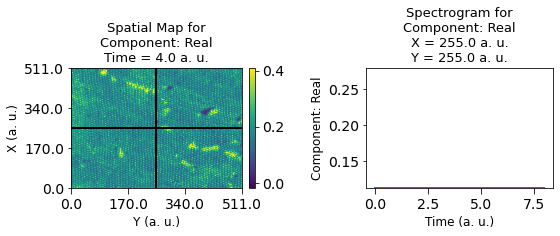

In [12]:
usid.plot_utils.use_nice_plot_params()
h5_main.visualize()

Here is a visualization of the nine image frames in the movie, generated using another handy function -
[plot_map_stack()](https://pycroscopy.github.io/sidpy/notebooks/02_visualization/plot_2d.html#plot_map_stack())

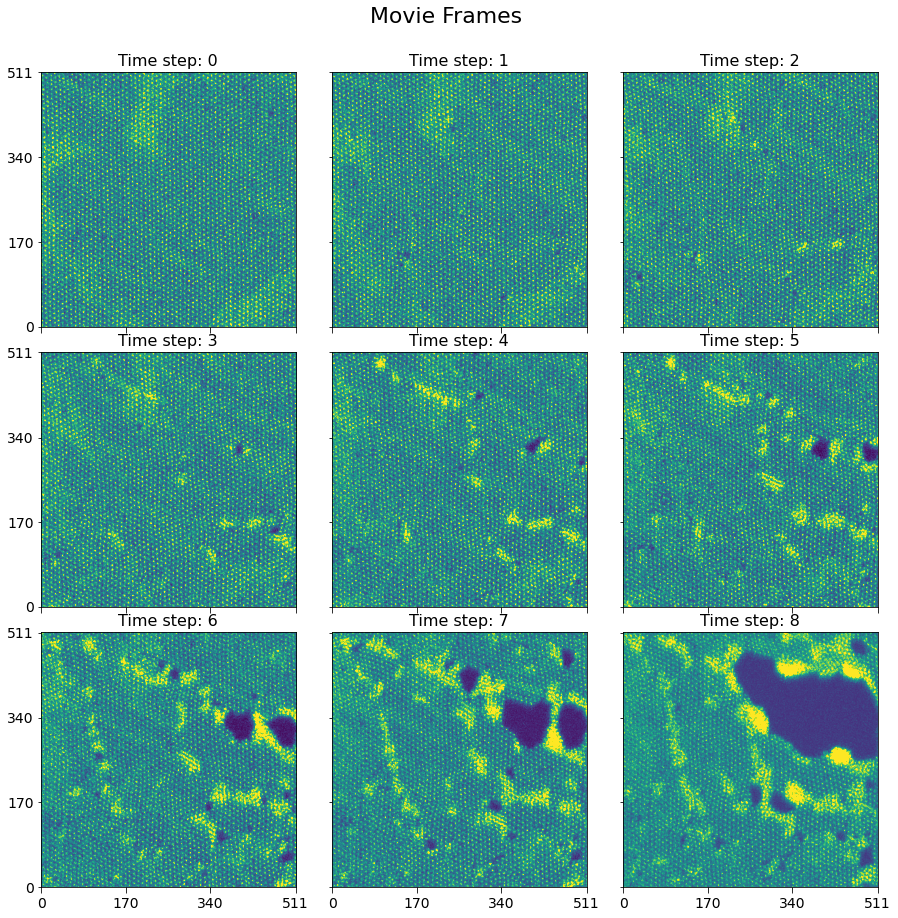

In [13]:
fig, axes = sidpy.plot_utils.plot_map_stack(h5_main.get_n_dim_form(), 
                                           reverse_dims=True, 
                                           subtitle='Time step:', 
                                           title_yoffset=0.94, 
                                           title='Movie Frames')

Ancillary Datasets
------------------
As mentioned in the documentation on USID, ``Ancillary Datasets`` are required to complete the information for any
dataset. Specifically, these datasets need to provide information about the values against which measurements were
acquired, in addition to explaining the original dimensionality (2 in this case) of the original dataset. Let's look
at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets``
linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

Ancillary Position Datasets
---------------------------



In [14]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)

Position Indices:
-------------------------
<HDF5 dataset "Position_Indices": shape (262144, 2), type "<u4">

Position Values:
-------------------------
<HDF5 dataset "Position_Values": shape (262144, 2), type "<f4">


Recall from the USID definition that the shape of the Position Ancillary datasets is ``(N, P)`` where ``N`` is the
number of Position dimensions and the ``P`` is the number of locations over which data was recorded. Here, we have
two position dimensions. Therefore ``N`` is ``2``. ``P`` matches with the first axis of the shape of ``h5_main``
which is ``16384``. Generally, there is no need to remember these rules or construct these ancillary datasets
manually since pyUSID has several functions that automatically simplify this process.

### Visualize the contents of the Position Ancillary Datasets
Notice below that there are two sets of lines, one for each dimension. The blue lines on the left-hand column
appear solid simply because this dimension (``X`` or columns) varies much faster than the other dimension (``Y`` or
rows). The first few rows of the dataset are visualized on the right-hand column.



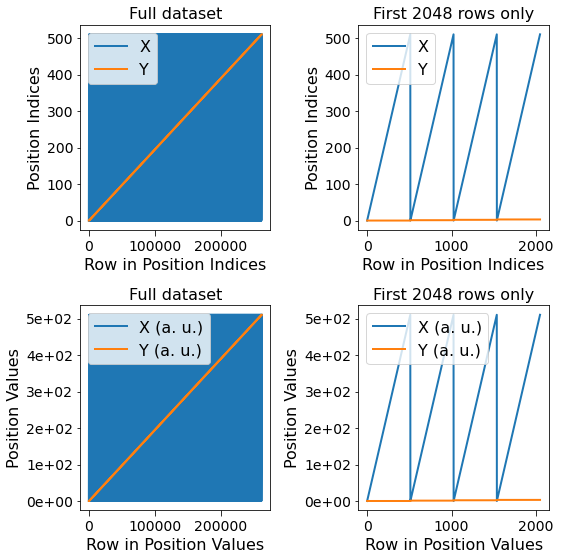

In [15]:
fig, all_axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

for axes, h5_pos_dset, dset_name in zip(all_axes,
                                        [h5_main.h5_pos_inds, h5_main.h5_pos_vals],
                                        ['Position Indices', 'Position Values']):
    axes[0].plot(h5_pos_dset[()])
    axes[0].set_title('Full dataset')
    axes[1].set_title('First 2048 rows only')
    axes[1].plot(h5_pos_dset[:2048])
    for axis in axes.flat:
        axis.set_xlabel('Row in ' + dset_name)
        axis.set_ylabel(dset_name)
        axis.legend(h5_main.pos_dim_labels)

for axis in all_axes[1]:
    sidpy.plot_utils.use_scientific_ticks(axis, is_x=False, formatting='%1.e')
    axis.legend(h5_main.pos_dim_descriptors)

fig.tight_layout()

Ancillary Spectroscopic Datasets
--------------------------------
Recall that the spectrum at each location was acquired as a function of ``9`` values of the single Spectroscopic
dimension - ``Time``. Therefore, according to USID, we should expect the Spectroscopic Dataset to be of shape
``(M, S)`` where M is the number of spectroscopic dimensions (``1`` in this case) and S is the total number of
spectroscopic values against which data was acquired at each location (``9`` in this case).



In [16]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 9), type "<u4">

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 9), type "<f4">


### Visualize the contents of the Spectroscopic Datasets
Observe the single curve that is associated with the single spectroscopic variable ``Time``. Also note that the contents
of the ``Spectroscopic Indices`` dataset are just a linearly increasing set of numbers starting from ``0`` according
to the definition of the ``Indices`` datasets which just count the nth value of independent variable that was varied.



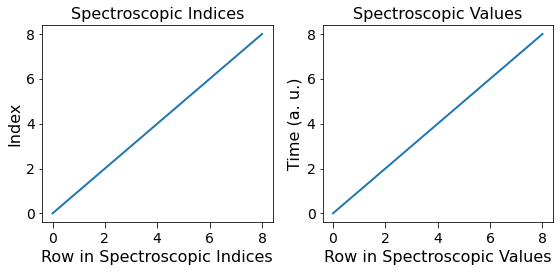

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for axis, data, title, y_lab in zip(axes.flat,
                                    [h5_main.h5_spec_inds[()].T, h5_main.h5_spec_vals[()].T],
                                    ['Spectroscopic Indices', 'Spectroscopic Values'],
                                    ['Index', h5_main.spec_dim_descriptors[0]]):
    axis.plot(data)
    axis.set_title(title)
    axis.set_xlabel('Row in ' + title)
    axis.set_ylabel(y_lab)

fig.tight_layout()

Why is this representation at odds with USID?
---------------------------------------------
On the surface, the above representation is indeed intuitive - the ``Time`` dimension is represented as a
``Spectroscopic`` dimension while the dimensions - ``X`` and ``Y`` are the ``Position`` dimensions that represent each
frame of the movie. In such datasets, each `observation` is a frame or 2D image in the movie, which are repeated along
the ``Time`` dimension.

However, according to the fundamental rules of ``USID``, the `observations` need to be flattened along the
``Spectroscopic`` axis, while these observations need to be stacked along the ``Position`` axis of a ``Main`` dataset.
In other words, the ``X`` and ``Y`` dimensions should actually be ``Spectroscopic`` dimensions and the ``Time``
dimension becomes the ``Position`` dimension, which is at odds with intuition and convention.

As a compromise, users are free to represent time series data in either format.

Strict USID representation of movies
------------------------------------
Below, we will look at the same data formatted according the strict interpretation of ``USID`` rules.
We start by first getting a reference to the desired dataset just as we did above:



In [18]:
h5_main_2 = usid.hdf_utils.find_dataset(h5_file, 'USID_Strict')[-1]
print(h5_main_2)

<HDF5 dataset "USID_Strict": shape (9, 262144), type "<f4">
located at: 
	/Measurement_001/Channel_000/USID_Strict 
Data contains: 
	Intensity (a. u.) 
Data dimensions and original shape: 
Position Dimensions: 
	Time - size: 9 
Spectroscopic Dimensions: 
	X - size: 512 
	Y - size: 512
Data Type:
	float32


We observe that this alternate form of representing the movie data results in the ``Time`` dimension now becoming
an example or ``Position`` dimension while the ``X`` and ``Y`` dimensions becoming ``Spectroscopic`` dimensions.
Consequently, this results in reversed shapes in the N-dimensional form of the data:



In [19]:
print('N-dimensional shape:\t{}'.format(h5_main_2.get_n_dim_form().shape))

N-dimensional shape:	(9, 512, 512)


### Ancillary datasets
Correspondingly, the ``Ancillary`` matrices would also be exchanged. Given that the values remain unchanged, the
visualization would also remain the same, except for the exchange in the ``Position`` and ``Spectroscopic`` dimensions

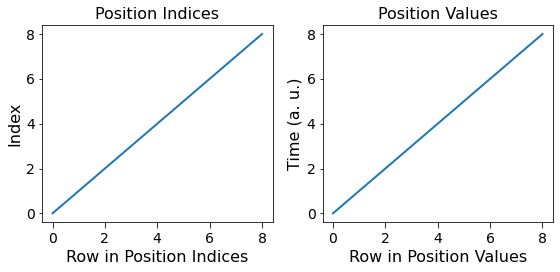

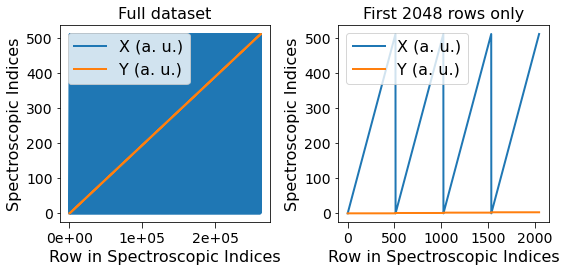

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for axis, data, title, y_lab in zip(axes.flat,
                                    [h5_main_2.h5_pos_inds[()], h5_main_2.h5_pos_vals[()]],
                                    ['Position Indices', 'Position Values'],
                                    ['Index', h5_main.spec_dim_descriptors[0]]):
    axis.plot(data)
    axis.set_title(title)
    axis.set_xlabel('Row in ' + title)
    axis.set_ylabel(y_lab)

fig.tight_layout()

fig, all_axes = plt.subplots(ncols=2, figsize=(8, 4))

for axes, h5_pos_dset, dset_name in zip([all_axes],
                                        [h5_main_2.h5_spec_inds[()].T],
                                    ['Spectroscopic Indices',  'Spectroscopic Values']):
    axes[0].plot(h5_pos_dset[()])
    sidpy.plot_utils.use_scientific_ticks(axes[0], is_x=True, formatting='%1.e')
    axes[0].set_title('Full dataset')
    axes[1].set_title('First 2048 rows only')
    axes[1].plot(h5_pos_dset[:2048])
    for axis in axes.flat:
        axis.set_xlabel('Row in ' + dset_name)
        axis.set_ylabel(dset_name)
        axis.legend(h5_main.pos_dim_labels)


for axis in all_axes:
    axis.legend(h5_main_2.spec_dim_descriptors)

fig.tight_layout()

Clean up
--------
Finally lets close the HDF5 file.



In [ ]:
h5_file.close()
os.remove(h5_path)